In [4]:
!pip install contractions

In [2]:
!pip install gensim

In [5]:
import pandas as pd
import numpy as np
import contractions
import nltk
import gensim
from nltk.corpus import stopwords
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from gensim.models import FastText
from contractions import contractions_dict
import string,re
from nltk.stem import WordNetLemmatizer

<ipython-input-5-a0e803aec4b4>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [6]:
data = pd.read_csv('C:\\Users\\NITRO 5\\Desktop\\tweet_emotions.csv')

In [7]:
data.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [9]:
data.sentiment.value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [10]:
df = data.copy()

In [11]:
df.dtypes

tweet_id      int64
sentiment    object
content      object
dtype: object

In [12]:
# Dropping rows with other emotion labels, i.e rounding number of emotions to only 5 basic ones 
df = df.drop(df[df.sentiment == 'boredom'].index)
df = df.drop(df[df.sentiment == 'enthusiasm'].index)
df = df.drop(df[df.sentiment == 'empty'].index)
df = df.drop(df[df.sentiment == 'fun'].index)
df = df.drop(df[df.sentiment == 'relief'].index)
df = df.drop(df[df.sentiment == 'surprise'].index)
df = df.drop(df[df.sentiment == 'love'].index)
df = df.drop(df[df.sentiment == 'hate'].index)

In [13]:
df.sentiment.value_counts()

neutral      8638
worry        8459
happiness    5209
sadness      5165
anger         110
Name: sentiment, dtype: int64

In [14]:
df

,tweet_id,sentiment,content
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...
6,1956968487,sadness,"I should be sleep, but im not! thinking about ..."
...,...,...,...
39992,1753918881,neutral,@jasimmo Ooo showing of your French skills!! l...
39993,1753918892,neutral,"@sendsome2me haha, yeah. Twitter has many uses..."
39994,1753918900,happiness,Succesfully following Tayla!!
39995,1753918954,neutral,@JohnLloydTaylor


C:\Users\NITRO 5\anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\NITRO 5\anaconda3\lib\site-packages\seaborn\categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


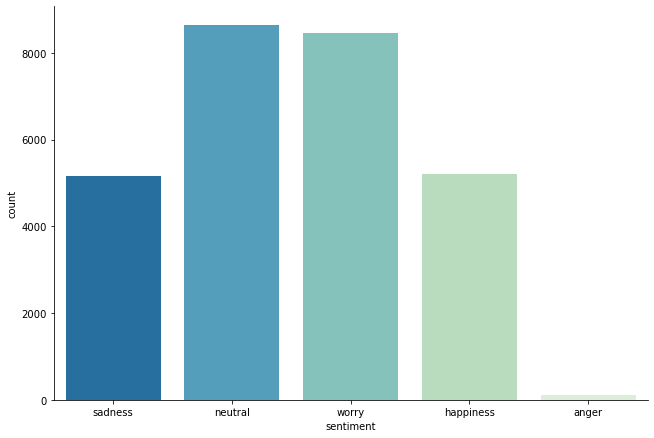

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.factorplot(x="sentiment", data=df, kind="count", size=6, aspect=1.5, palette="GnBu_r")
plt.show();


In [16]:
df.reset_index(drop=True,inplace=True)

In [17]:
df

,tweet_id,sentiment,content
0,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
1,1956967696,sadness,Funeral ceremony...gloomy friday...
2,1956968416,neutral,@dannycastillo We want to trade with someone w...
3,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...
4,1956968487,sadness,"I should be sleep, but im not! thinking about ..."
...,...,...,...
27576,1753918881,neutral,@jasimmo Ooo showing of your French skills!! l...
27577,1753918892,neutral,"@sendsome2me haha, yeah. Twitter has many uses..."
27578,1753918900,happiness,Succesfully following Tayla!!
27579,1753918954,neutral,@JohnLloydTaylor


In [18]:
df.shape

(27581, 3)

In [19]:
df.drop('tweet_id',axis=1,inplace=True)

In [20]:
df.columns = ['sentiment','text']

In [21]:
df_pos = pd.read_csv("https://raw.githubusercontent.com/RepoMan20/Automate-detection-of-emotions-using-ML/master/lexicons/positive.csv")
df_neg = pd.read_csv("https://raw.githubusercontent.com/RepoMan20/Automate-detection-of-emotions-using-ML/master/lexicons/negative.csv")

In [22]:
df_pos.head()

,words
0,ABLE
1,ABUNDANCE
2,ABUNDANT
3,ACCLAIMED
4,ACCOMPLISH


In [23]:
df_neg.head()

,words
0,ABANDON
1,ABANDONED
2,ABANDONING
3,ABANDONMENT
4,ABANDONMENTS


In [24]:
def expand_text(text):
    text = text.lower()
    text = text.replace("`","'")
    
    #Expand Contractions
    contraction_dict = contractions_dict
    contraction_keys = list(contraction_dict.keys())
    
    for word in text.split():
        if word in contraction_keys:
            text = text.replace(word, contraction_dict[word])
        else:
            continue
    
    return text    

In [25]:
def clean_text(text):
    text = text.translate(string.punctuation)
    text = text.lower().split()
    
    df_pos_words = list(df_pos.words)
    df_neg_words = list(df_neg.words)
    
    positive = []
    for i in range(0,len(df_pos_words)):
        positive.append(df_pos_words[i].lower().replace(" ",""))
        
    negative = []
    for i in range(0,len(df_neg_words)):
        negative.append(df_neg_words[i].lower().replace(" ",""))
        
    pos_set = set(positive)
    neg_set = set(negative)
    
    keywords = set(["above","and","below","not"])
    keywords.update(pos_set)
    keywords.update(neg_set)
    
    stopwords_set = set(stopwords.words('english'))
    stops = stopwords_set - keywords
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    
    text = re.sub(r"[^A-Za-z0-9^,!./\'+-=]"," ",text)
    text = re.sub(r"what's","what is",text)
    text = re.sub(r"\'s"," ",text)
    text = re.sub(r"\'ve"," have ",text)
    text = re.sub(r"n't"," not ",text)
    text = re.sub(r"i'm"," i am ",text)
    text = re.sub(r"\'re"," are ",text)
    text = re.sub(r"\'d", " would ",text)
    text = re.sub(r"\'ll", " will ",text)
    text = re.sub(r","," ",text)
    text = re.sub(r"\."," ",text)
    text = re.sub(r"!"," ! ",text)
    text = re.sub(r"\/"," ",text)
    text = re.sub(r"\^"," ^ ",text)
    text = re.sub(r"\+"," + ",text)
    text = re.sub(r"\-"," - ",text)
    text = re.sub(r"\="," = ",text)
    text = re.sub(r"'"," ",text)
    text = re.sub(r"(\d+)(k)",r"\g<1>000",text)
    text = re.sub(r":", " : ",text)
    text = re.sub(r" e g "," eg ",text)
    text = re.sub(r"b g "," bg ",text)
    text = re.sub(r" u s "," american ",text)
    text = re.sub(r"\0s","0",text)
    text = re.sub(r"e - mail","email",text)
    text = re.sub(r"\s{2,}"," ",text)
    
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(lemmatized_words)
    
    return text

In [26]:
df

,sentiment,text
0,sadness,Layin n bed with a headache ughhhh...waitin o...
1,sadness,Funeral ceremony...gloomy friday...
2,neutral,@dannycastillo We want to trade with someone w...
3,worry,Re-pinging @ghostridah14: why didn't you go to...
4,sadness,"I should be sleep, but im not! thinking about ..."
...,...,...
27576,neutral,@jasimmo Ooo showing of your French skills!! l...
27577,neutral,"@sendsome2me haha, yeah. Twitter has many uses..."
27578,happiness,Succesfully following Tayla!!
27579,neutral,@JohnLloydTaylor


In [27]:
df['text'] = df['text'].progress_apply(lambda x : expand_text(x))

  0%|          | 0/27581 [00:00<?, ?it/s]

In [28]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\NITRO
[nltk_data]     5\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\NITRO
[nltk_data]     5\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [29]:
df['text'] = df['text'].progress_apply(lambda x: clean_text(x))

  0%|          | 0/27581 [00:00<?, ?it/s]

In [30]:
df.sentiment.value_counts()

neutral      8638
worry        8459
happiness    5209
sadness      5165
anger         110
Name: sentiment, dtype: int64

In [31]:
df

,sentiment,text
0,sadness,layin n bed headache ughhhh waitin call
1,sadness,funeral ceremony gloomy friday
2,neutral,dannycastillo want trade someone houston ticke...
3,worry,re - pinging ghostridah14 : not go prom bc bf ...
4,sadness,sleep im not ! thinking old friend want marrie...
...,...,...
27576,neutral,jasimmo ooo showing french skill ! ! lol thing...
27577,neutral,sendsome2me haha yeah twitter many us know ppl...
27578,happiness,succesfully following tayla ! !
27579,neutral,johnlloydtaylor


In [32]:
from sklearn.preprocessing import LabelEncoder
lbl_enc = LabelEncoder()

In [33]:
y = lbl_enc.fit_transform(df.sentiment.values)

In [34]:
y_series = pd.Series(y)
emo_cols_series = pd.Series(lbl_enc.inverse_transform(y)) 

In [35]:
emo_df = pd.DataFrame()
emo_df = pd.concat([emo_cols_series,y_series],axis=1)
emo_df.columns=['emotion','Label_mapped']

In [36]:
emo_df = emo_df.drop_duplicates()
emo_df.sort_values(by=['Label_mapped'],ascending= True)

,emotion,Label_mapped
394,anger,0
34,happiness,1
2,neutral,2
0,sadness,3
3,worry,4


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train,X_val,y_train,y_val = train_test_split(df.text.values,df.sentiment.values,random_state=42, test_size=0.1, shuffle=True)

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1)

In [39]:
tfidf.fit(list(X_train) + list(X_val))
X_train_tfidf = tfidf.transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
count_vec = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3))
count_vec.fit(list(X_train) + list(X_val))

CountVectorizer(ngram_range=(1, 3), token_pattern='\\w{1,}')

In [41]:
X_train_count_vec = count_vec.transform(X_train)
X_val_count_vec = count_vec.transform(X_val)

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred = nb.predict(X_val_tfidf)
print('naive bayes tfidf accuracy %s' % accuracy_score(y_pred, y_val))

naive bayes tfidf accuracy 0.4356650960492932


In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_val))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         0
   happiness       0.28      0.60      0.38       250
     neutral       0.56      0.40      0.47      1151
     sadness       0.09      0.51      0.16        96
       worry       0.62      0.43      0.50      1262

    accuracy                           0.44      2759
   macro avg       0.31      0.39      0.30      2759
weighted avg       0.54      0.44      0.47      2759



C:\Users\NITRO 5\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\NITRO 5\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\NITRO 5\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train_tfidf,y_train)
y_pred2 = rf.predict(X_val_tfidf)
print('Random forest tfidf accuracy %s' % accuracy_score(y_pred2, y_val))

Random forest tfidf accuracy 0.4498006524102936


In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_pred2, y_val))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         0
   happiness       0.42      0.54      0.47       407
     neutral       0.57      0.44      0.49      1082
     sadness       0.17      0.44      0.24       202
       worry       0.53      0.43      0.47      1068

    accuracy                           0.45      2759
   macro avg       0.34      0.37      0.34      2759
weighted avg       0.50      0.45      0.46      2759



C:\Users\NITRO 5\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\NITRO 5\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\NITRO 5\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
from sklearn.linear_model import SGDClassifier
lsvm = SGDClassifier(alpha=0.001, random_state=5, max_iter=15, tol=None)
lsvm.fit(X_train_tfidf, y_train)
y_pred_sgd = lsvm.predict(X_val_tfidf)
print('SGD using tfidf accuracy %s' % accuracy_score(y_pred_sgd, y_val))

SGD using tfidf accuracy 0.4686480608916274


In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_pred_sgd, y_val))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         1
   happiness       0.55      0.51      0.53       580
     neutral       0.54      0.44      0.49      1009
     sadness       0.26      0.45      0.33       304
       worry       0.47      0.48      0.48       865

    accuracy                           0.47      2759
   macro avg       0.37      0.38      0.36      2759
weighted avg       0.49      0.47      0.48      2759



In [48]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1.0)
lr.fit(X_train_tfidf,y_train)
y_pred = lr.predict(X_val_tfidf)
print('Accuracy with Logistic Regression and Tf-idf is {}'.format(accuracy_score(y_pred,y_val)))

Accuracy with Logistic Regression and Tf-idf is 0.4606741573033708


C:\Users\NITRO 5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         0
   happiness       0.43      0.58      0.49       391
     neutral       0.58      0.44      0.50      1104
     sadness       0.23      0.43      0.30       271
       worry       0.51      0.45      0.48       993

    accuracy                           0.46      2759
   macro avg       0.35      0.38      0.35      2759
weighted avg       0.50      0.46      0.47      2759



C:\Users\NITRO 5\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\NITRO 5\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\NITRO 5\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_count_vec, y_train)
y_pred = nb.predict(X_val_count_vec)
print('naive bayes count_vec accuracy %s' % accuracy_score(y_pred, y_val))

naive bayes count_vec accuracy 0.43675244653860096


In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_val))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         0
   happiness       0.46      0.54      0.50       454
     neutral       0.63      0.45      0.52      1164
     sadness       0.28      0.44      0.34       332
       worry       0.44      0.48      0.46       809

    accuracy                           0.47      2759
   macro avg       0.36      0.38      0.36      2759
weighted avg       0.50      0.47      0.48      2759



C:\Users\NITRO 5\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\NITRO 5\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\NITRO 5\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train_count_vec,y_train)
y_pred2 = rf.predict(X_val_count_vec)
print('Random forest tfidf accuracy %s' % accuracy_score(y_pred2, y_val))

Random forest tfidf accuracy 0.4454512504530627


In [57]:
from sklearn.metrics import classification_report
print(classification_report(y_pred2,y_val))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         0
   happiness       0.32      0.59      0.42       292
     neutral       0.68      0.41      0.51      1382
     sadness       0.18      0.45      0.26       206
       worry       0.46      0.46      0.46       879

    accuracy                           0.45      2759
   macro avg       0.33      0.38      0.33      2759
weighted avg       0.53      0.45      0.46      2759



C:\Users\NITRO 5\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\NITRO 5\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\NITRO 5\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
from sklearn.linear_model import SGDClassifier
lsvm = SGDClassifier()
lsvm.fit(X_train_count_vec, y_train)
y_pred = lsvm.predict(X_val_count_vec)
print('svm using countvec accuracy %s' % accuracy_score(y_pred, y_val))

svm using countvec accuracy 0.47082276187024286


In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_val))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         0
   happiness       0.46      0.54      0.50       454
     neutral       0.63      0.45      0.52      1164
     sadness       0.28      0.44      0.34       332
       worry       0.44      0.48      0.46       809

    accuracy                           0.47      2759
   macro avg       0.36      0.38      0.36      2759
weighted avg       0.50      0.47      0.48      2759



C:\Users\NITRO 5\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\NITRO 5\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\NITRO 5\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1.0)
lr.fit(X_train_count_vec,y_train)
y_pred = lr.predict(X_val_count_vec)
print('Accuracy with Logistic Regression and CountVec is {}'.format(accuracy_score(y_pred,y_val)))

Accuracy with Logistic Regression and CountVec is 0.4686480608916274


C:\Users\NITRO 5\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_val,y_pred_sgd))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         4
   happiness       0.51      0.55      0.53       532
     neutral       0.44      0.54      0.49       827
     sadness       0.45      0.26      0.33       518
       worry       0.48      0.47      0.48       878

    accuracy                           0.47      2759
   macro avg       0.38      0.37      0.36      2759
weighted avg       0.47      0.47      0.46      2759

